最適化を開始...
最適化時間: 3.37秒
最終忠実度: 1.000000


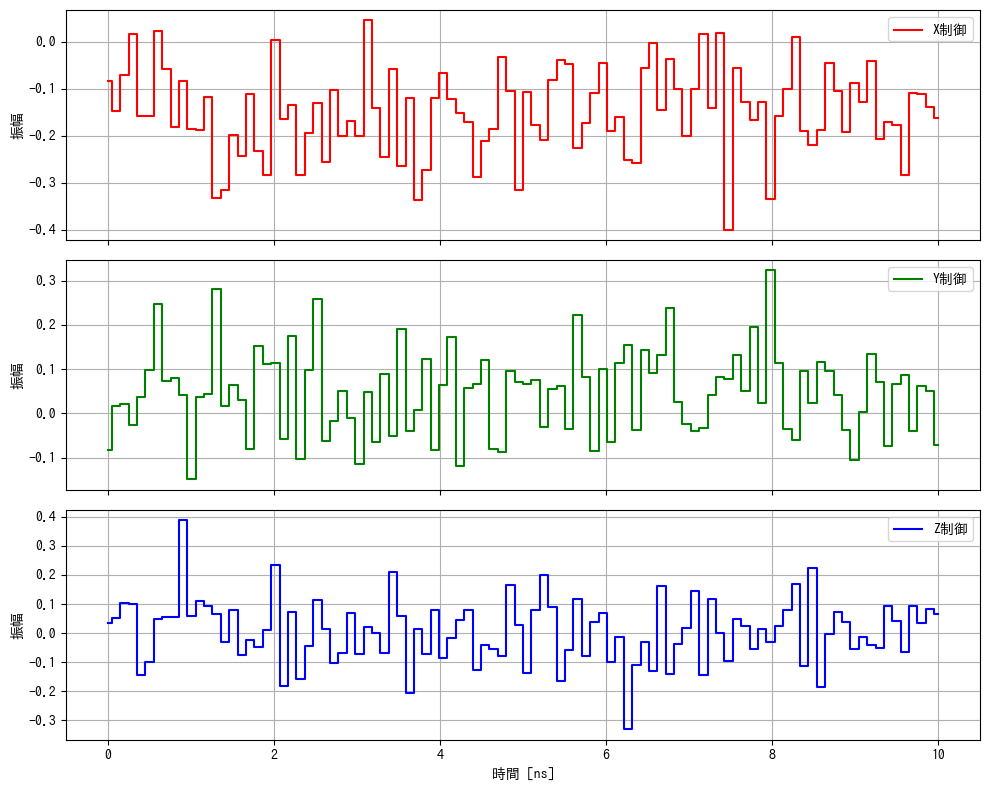

In [1]:
# 必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from scipy.linalg import expm
import time
matplotlib.font_manager.fontManager.addfont("fonts/ipag.ttf")
matplotlib.rcParams['font.family'] = 'IPAGothic'


# シミュレーションパラメータ
total_time = 10.0  # 総時間 [ns]
n_steps = 100  # 時間ステップ数
dt = total_time / n_steps

# パウリ行列
sx = np.array([[0, 1], [1, 0]], dtype=np.complex128)
sy = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
sz = np.array([[1, 0], [0, -1]], dtype=np.complex128)
identity = np.eye(2, dtype=np.complex128)

# 状態
down = np.array([[0], [1]], dtype=np.complex128)  # |1⟩
up = np.array([[1], [0]], dtype=np.complex128)    # |0⟩

# 制御ハミルトニアン
H_controls = [sx, sy, sz]
H_drift = np.zeros((2, 2), dtype=np.complex128)

# コスト関数（忠実度を最大化）
def calculate_fidelity(final_state, target_state):
    """状態ベクトル間の忠実度を計算"""
    return np.abs(target_state.conj().T @ final_state)[0, 0]**2

def evolve_state(pulses, initial_state):
    """パルスを使って状態を時間発展させる"""
    state = initial_state.copy()
    n_controls = len(pulses)
    
    for t in range(n_steps):
        # 現在の時間ステップでのハミルトニアン
        H = H_drift.copy()
        for i in range(n_controls):
            H += pulses[i][t] * H_controls[i]
        
        # プロパゲータを計算して状態を更新
        U = expm(-1j * H * dt)
        state = U @ state
    
    return state

def cost_function(x):
    """最適化のためのコスト関数"""
    # パラメータをパルスに変換
    pulses = [
        x[:n_steps],                # X制御
        x[n_steps:2*n_steps],       # Y制御
        x[2*n_steps:3*n_steps]      # Z制御
    ]
    
    # 状態を時間発展
    final_state = evolve_state(pulses, down)
    
    # 忠実度を計算（最大化のために負の値を返す）
    fidelity = calculate_fidelity(final_state, up)
    return -fidelity  # 最小化問題に変換

# 初期パルス（小さなランダム値）
np.random.seed(42)
initial_pulses_flat = 0.1 * np.random.randn(3 * n_steps)

# パルス制約
pulse_bounds = [(-1.0, 1.0)] * (3 * n_steps)

# 最適化を実行
print("最適化を開始...")
start_time = time.time()
result = minimize(
    cost_function,           # コスト関数
    initial_pulses_flat,     # 初期パラメータ値（3*n_stepsの長さの配列）
    method='L-BFGS-B',       # 最適化アルゴリズム
    bounds=pulse_bounds,     # パラメータの制約条件
    options={'maxiter': 200, 'disp': True}  # 最大反復回数と進捗表示
)
end_time = time.time()
print(f"最適化時間: {end_time - start_time:.2f}秒")

# 最適化されたパルスを取得
optimized_pulses = [
    result.x[:n_steps],
    result.x[n_steps:2*n_steps],
    result.x[2*n_steps:3*n_steps]
]

# 最終的な忠実度を計算
final_state = evolve_state(optimized_pulses, down)
fidelity = calculate_fidelity(final_state, up)
print(f"最終忠実度: {fidelity:.6f}")

# 最適化されたパルスを表示
time_grid = np.linspace(0, total_time, n_steps)
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].step(time_grid, optimized_pulses[0], 'r-', where='mid', label='X制御')
axes[0].set_ylabel('振幅')
axes[0].legend()
axes[0].grid(True)

axes[1].step(time_grid, optimized_pulses[1], 'g-', where='mid', label='Y制御')
axes[1].set_ylabel('振幅')
axes[1].legend()
axes[1].grid(True)

axes[2].step(time_grid, optimized_pulses[2], 'b-', where='mid', label='Z制御')
axes[2].set_xlabel('時間 [ns]')
axes[2].set_ylabel('振幅')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# 忠実度の履歴
if hasattr(result, 'fun_history'):
    plt.figure(figsize=(8, 5))
    plt.plot(-np.array(result.fun_history), 'o-')
    plt.xlabel('反復回数')
    plt.ylabel('忠実度')
    plt.grid(True)
    plt.show()

コールバック付きで最適化を開始...
最適化時間: 3.50秒


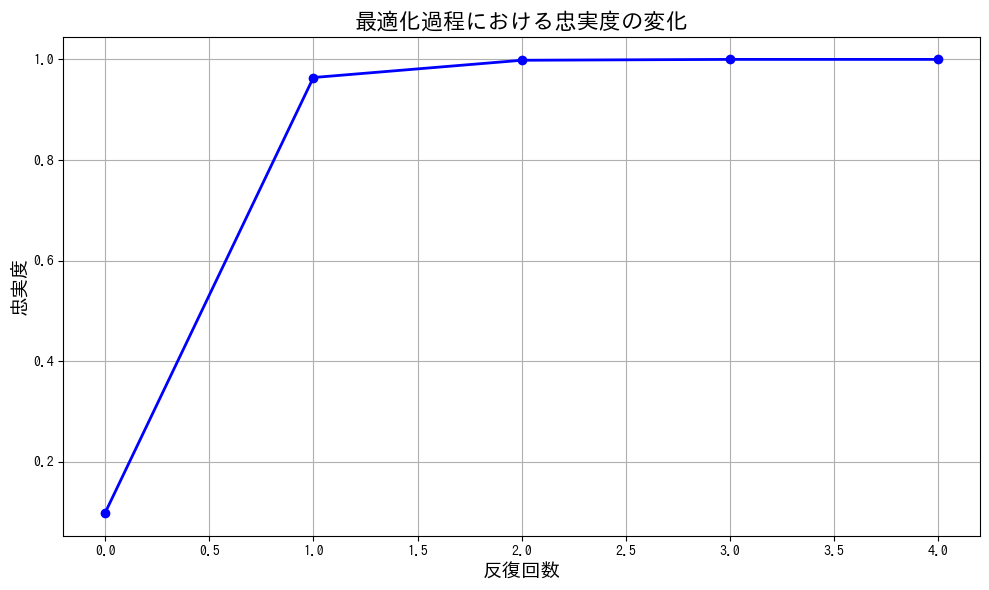

初期忠実度: 0.098712
最終忠実度: 1.000000
改善率: 90.13%


In [ ]:
# 必要なライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from scipy.linalg import expm
import time
matplotlib.font_manager.fontManager.addfont("fonts/ipag.ttf")
matplotlib.rcParams['font.family'] = 'IPAGothic'

# FoM履歴を保存するための変数
fom_history = []

# コールバック関数
def callback_func(x):
    # パラメータをパルスに変換
    pulses = [
        x[:n_steps],                # X制御
        x[n_steps:2*n_steps],       # Y制御
        x[2*n_steps:3*n_steps]      # Z制御
    ]
    
    # 状態を時間発展
    final_state = evolve_state(pulses, down)
    
    # 忠実度を計算
    fidelity = calculate_fidelity(final_state, up)
    fom_history.append(fidelity)
    
    return False  # 最適化を続行

# 最適化を実行（コールバック関数を追加）
print("コールバック付きで最適化を開始...")
start_time = time.time()
result = minimize(
    cost_function,
    initial_pulses_flat,
    method='L-BFGS-B',
    bounds=pulse_bounds,
    callback=callback_func,
    options={'maxiter': 200, 'disp': True}
)
end_time = time.time()
print(f"最適化時間: {end_time - start_time:.2f}秒")



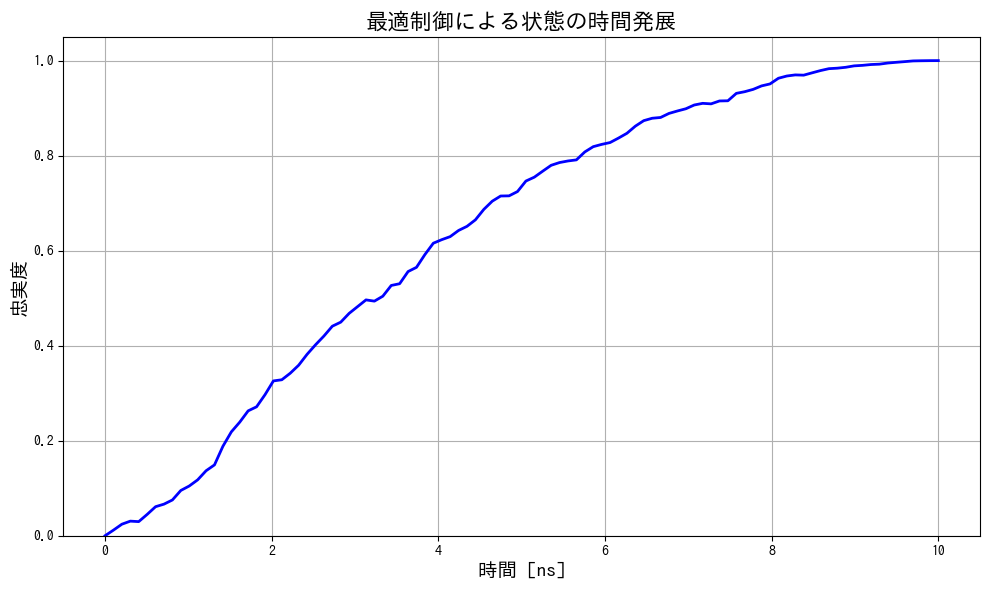

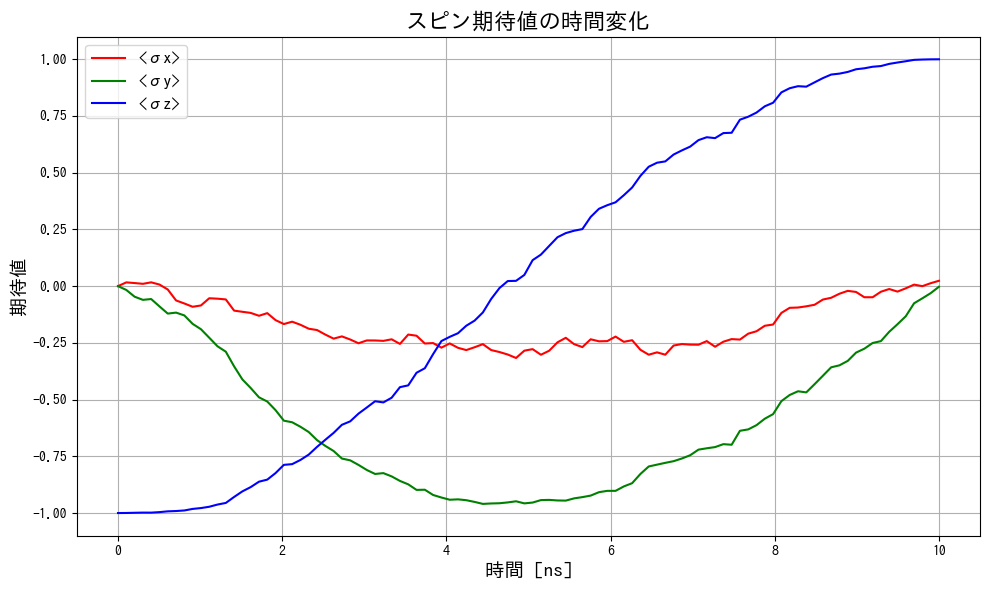

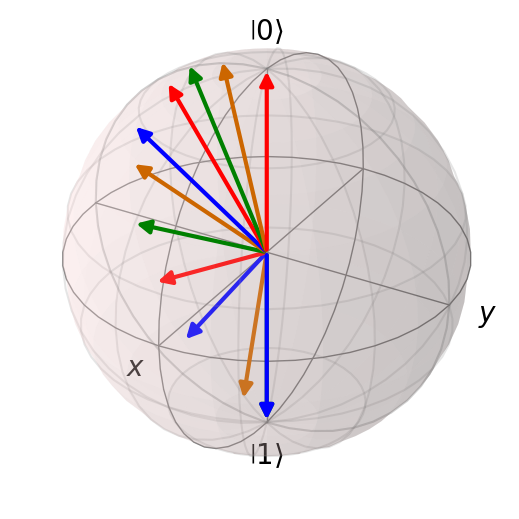

In [6]:
# QuTiPを使用した電子スピン制御のシミュレーション
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import matplotlib
matplotlib.font_manager.fontManager.addfont("fonts/ipag.ttf")
matplotlib.rcParams['font.family'] = 'IPAGothic'

# シミュレーションパラメータ
total_time = 10.0  # 総時間 [ns]
n_steps = 100  # 時間ステップ数
dt = total_time / n_steps
tlist = np.linspace(0, total_time, n_steps)

# QuTiPでスピン演算子を定義
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()
si = qt.identity(2)

# 状態を定義
down = qt.basis(2, 1)  # |1⟩ = (0, 1)
up = qt.basis(2, 0)    # |0⟩ = (1, 0)

# 最適化されたパルスを使用（前のセルの結果を使用）
# optimized_pulsesはすでにSciPyの最適化結果から取得済みと仮定

# コントロールハミルトニアンのリスト
H_controls = [sx, sy, sz]
H_drift = 0 * qt.identity(2)  # ドリフトハミルトニアン（ここではゼロ）

# 時間依存ハミルトニアンの定義
def H_t(t, args):
    # 時間tでのパルス値を補間
    idx = int(t / total_time * (n_steps - 1))
    idx = min(idx, n_steps - 1)  # 範囲を超えないように
    
    # ハミルトニアンを構築
    H = H_drift
    for i, H_control in enumerate(H_controls):
        H += optimized_pulses[i][idx] * H_control
    
    return H

# 時間発展の計算
result = qt.mesolve(H_t, down, tlist, [], [])

# 目標状態との忠実度を計算
fidelities = []
for state in result.states:
    fidelity = qt.fidelity(state, up)
    fidelities.append(fidelity)

# 忠実度の時間変化をプロット
plt.figure(figsize=(10, 6))
plt.plot(tlist, fidelities, 'b-', linewidth=2)
plt.xlabel('時間 [ns]', fontsize=14)
plt.ylabel('忠実度', fontsize=14)
plt.title('最適制御による状態の時間発展', fontsize=16)
plt.grid(True)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()



# スピン期待値の時間変化
sx_exp = [qt.expect(sx, state) for state in result.states]
sy_exp = [qt.expect(sy, state) for state in result.states]
sz_exp = [qt.expect(sz, state) for state in result.states]

plt.figure(figsize=(10, 6))
plt.plot(tlist, sx_exp, 'r-', label='<σx>')
plt.plot(tlist, sy_exp, 'g-', label='<σy>')
plt.plot(tlist, sz_exp, 'b-', label='<σz>')
plt.xlabel('時間 [ns]', fontsize=14)
plt.ylabel('期待値', fontsize=14)
plt.title('スピン期待値の時間変化', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# ブロッホ球上での状態の可視化
b = qt.Bloch()   # ベクトルの色を青に設定
b.add_states(result.states[::10])  # 表示を見やすくするために間引く
b.add_states([down])  # 初期状態を赤色の点で表示
b.add_states([up])    # 目標状態を緑色の点で表示
b.show()